# Vector to EOPatch
- Add vector field to eopatches
- Creation of extent, boundary and distance on each eopatch
- Plots of extent, boundary and distance for a specified eopatch

In [6]:
from abc import abstractmethod
import os
import boto3
import fs
from fs_s3fs import S3FS

import pyproj
from shapely.ops import transform

from shapely.geometry import Polygon,MultiPolygon
from datetime import datetime, timedelta
import dateutil
import rasterio
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from tqdm.notebook import tqdm
from typing import List, Union, Tuple, Optional

from skimage.morphology import binary_dilation, disk
from skimage.measure import label
from scipy.ndimage import distance_transform_edt

from sentinelhub import CRS, BBox

from eolearn.core import FeatureType, EOPatch, EOTask, EOWorkflow, LinearWorkflow, LoadTask, SaveTask, \
    OverwritePermission, EOExecutor, SaveToDisk
from eolearn.geometry import VectorToRaster

from fd.utils_plot import (draw_vector_timeless, 
                           draw_true_color, 
                           draw_bbox, 
                           draw_mask, 
                           get_extent)
from fd.vectordata_to_eopatch import(get_workflow_vector_to_eopatch)


In [7]:
### paths
path = '/data-id/lscalambrin'
path_shapes = path+'/vectores/LotesDibujados/Pergamino'
pergamino_gpdf = gpd.read_file(path_shapes+'/20180228_Completo_32720.shp')
save_patch = '/data-id/lscalambrin/proyecto_integrador/segmentation/gral_lopez/eopatches2'

### features
extent_feature = (FeatureType.MASK_TIMELESS, 'EXTENT')
boundary_feature = (FeatureType.MASK_TIMELESS, 'BOUNDARY')
distance_feature = (FeatureType.DATA_TIMELESS, 'DISTANCE')

### loadTask and savetask
load_task = LoadTask(path = save_patch)

save_task = SaveToDisk(save_patch, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)


### Shape for masks
raster_shape = (1189, 1263)

workflow = get_workflow_vector_to_eopatch(load_task, save_task, pergamino_gpdf, extent_feature, raster_shape, boundary_feature, distance_feature)

/home/lscalambrin/miniconda3/envs/deep_crop/lib/python3.8/site-packages/eolearn/core/core_tasks.py:134: DeprecationWarning: This task is deprecated, use SaveTask instead
  warnings.warn('This task is deprecated, use SaveTask instead', DeprecationWarning)


#### Total execution in parallel

In [9]:
eopatches_list = [eop_name for eop_name in os.listdir(save_patch) if (eop_name!='.ipynb_checkpoints')]
exec_args = []

for eopatch_name in tqdm(eopatches_list, total=len(eopatches_list)):

    single_exec_dict = {}
    single_exec_dict[load_task] = dict(eopatch_folder=f'{eopatch_name}')
    single_exec_dict[save_task] = dict(eopatch_folder=f'{eopatch_name}')
    exec_args.append(single_exec_dict)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
MAX_WORKERS = 20

executor = EOExecutor(workflow, exec_args, save_logs=True, logs_folder='.')

executor.run(workers=MAX_WORKERS)

  0%|          | 0/1 [00:00<?, ?it/s]

# Plots:
- TrueColor
- Extent
- Boundary
- Distance

In [37]:
### Load eopatch
idx = 0
eop = EOPatch.load(save_patch+f'/eopatch_{idx}')

#### Truecolor plot

(727681.9607020699, 740307.9548622062, 6251016.769067803, 6262911.892863703)

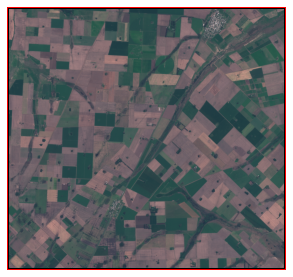

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
draw_true_color(ax, eop, time_idx=0, factor=3.5, feature_name='BANDS', bands=(3, 2, 1), grid=False)
draw_bbox(ax, eop)
plt.axis('off')
# plt.savefig(fname = 'trueColor_eopatch.png')

#### Mask plot

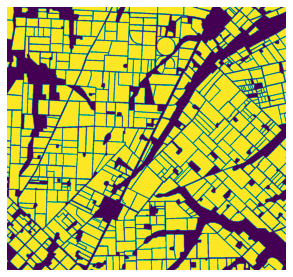

In [6]:
fig = plt.figure(figsize=(5,5))
eop.mask_timeless['EXTENT'].squeeze()
im = plt.imshow(eop.mask_timeless['EXTENT'].squeeze())
# fig.suptitle('Raster mask showing crop type for each polygon',y=0.93, size=15)
# plt.savefig(fname = 'mask.png')
plt.axis('off')
plt.show()

#### Extent plot

(727681.9607020699, 740307.9548622062, 6251016.769067803, 6262911.892863703)

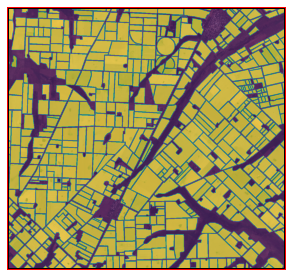

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
draw_true_color(ax, eop, time_idx=2, factor=3.5, feature_name='BANDS', bands=(3, 2, 1), grid=False)
draw_bbox(ax, eop)
draw_mask(ax, eop, time_idx=None, feature_name='EXTENT', alpha=.6)
plt.axis('off')
# plt.savefig(fname = 'extent.png')

#### Boundary plot

(727681.9607020699, 740307.9548622062, 6251016.769067803, 6262911.892863703)

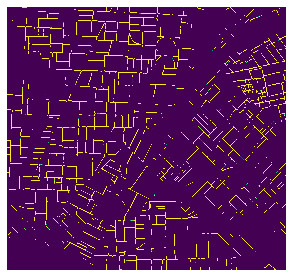

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
# draw_true_color(ax, eop, time_idx=1, factor=3.5, feature_name='BANDS', bands=(3,2,1), grid=False)
# draw_bbox(ax, eop)
draw_mask(ax, eop, time_idx=None, feature_name='BOUNDARY', alpha=1, vmin=.49,vmax=.5)
plt.axis('off')